In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import itertools
import metodos_labo as labo

plt.style.use('./informes.mplstyle')

In [2]:
corrientes = [0.2,0.4,0.6,0.8,1]

t   =   []
v   =   []
tf  =   [] #Termocupla Fria
tc  =   [] #Termocupla Caliente
delta_t =   []

for i in range(len(corrientes)):
    df = pd.read_csv(f'Mediciones/Clase 3/celda_temp_fija_I={corrientes[i]}.csv')
    t.append(df['Tiempo [s]'].values)
    v.append(df['Tension generador [V]'].values)
    tf_temp =   df['Tensión termocupla fria [V]'].values
    tc_temp =   df['Tensión termocupla caliente [V]'].values
    tf_temp = tf_temp*1e3 #Pasa el valor a mV
    tc_temp = tc_temp*1e3
    tf.append(tf_temp*22.619 + 28.0634) #Pasa el valor a temperatura [C]
    tc.append(tc_temp*22.671 + 28.0135)
    delta_t.append((tc[i] - tf[i]))
    

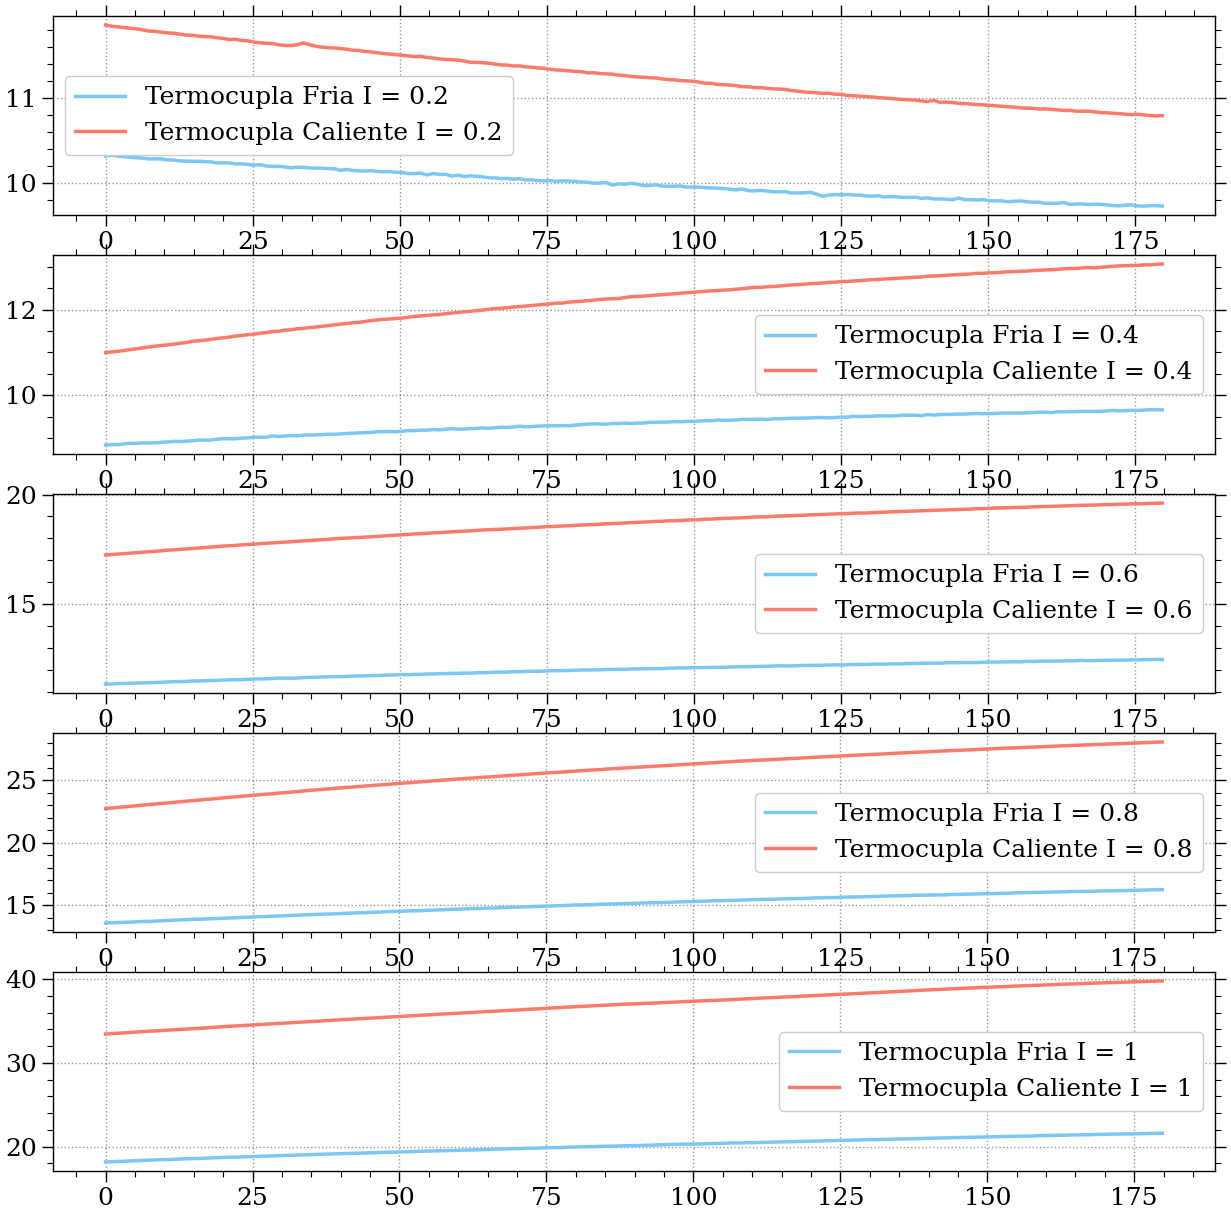

In [3]:
fig,ax = plt.subplots(len(corrientes),1, figsize = (15,15))

for i in range(len(corrientes)):
    ax[i].plot(t[i],tf[i],label = f'Termocupla Fria I = {corrientes[i]}', color = 'C1')
    ax[i].plot(t[i],tc[i],label = f'Termocupla Caliente I = {corrientes[i]}',color = 'C3')
    ax[i].legend()

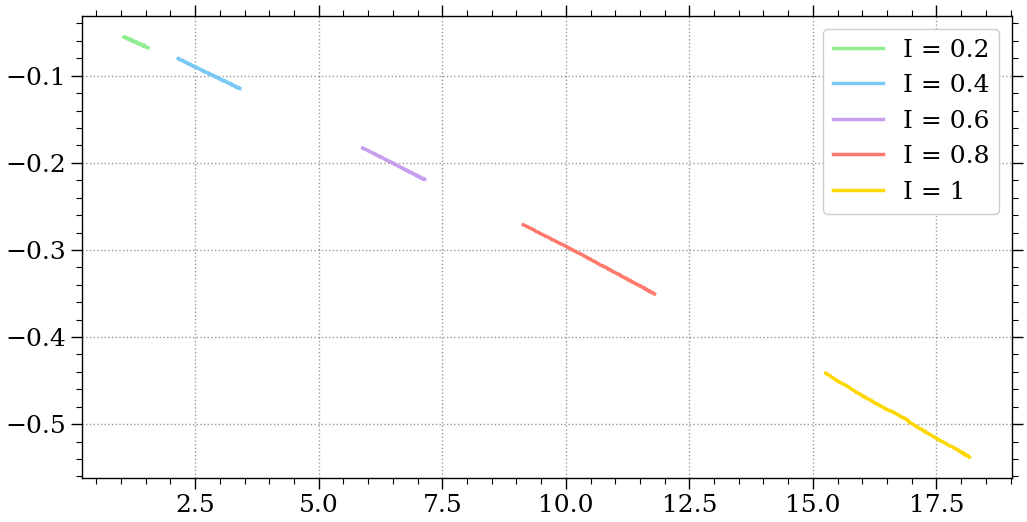

In [4]:
fig,ax = plt.subplots()
for i in range(len(corrientes)):
    ax.plot(delta_t[i],v[i],label = f'I = {corrientes[i]}')
ax.legend()

m = -0.0279; b = -0.0212


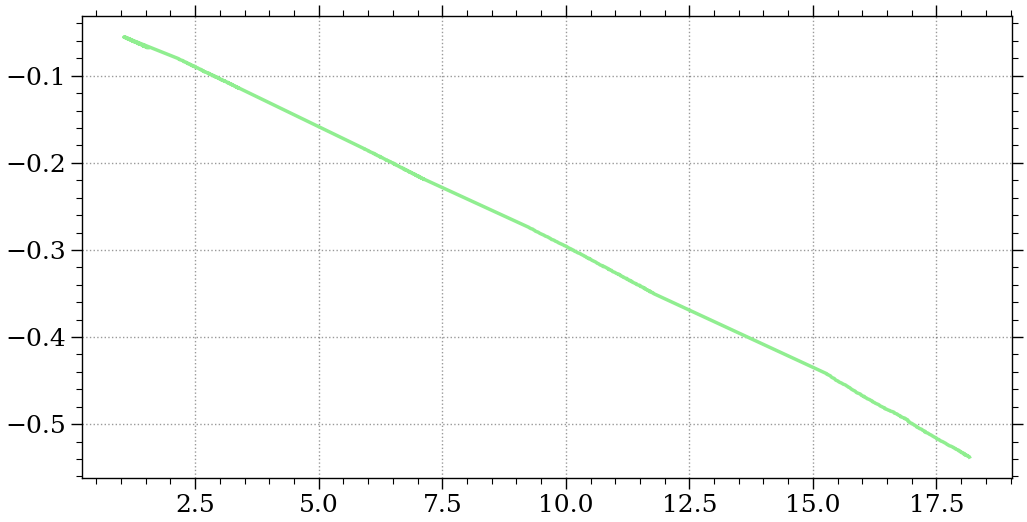

In [5]:
def lineal(T,m,b):
    return m*T +b
delta_t_concatenated = np.concatenate(delta_t)
v_concatenated = np.concatenate(v)

fig, ax = plt.subplots()
ax.plot(delta_t_concatenated,v_concatenated)
popt,pcov = curve_fit(lineal,delta_t_concatenated,v_concatenated)
Seebeck_juntando_rangos = popt[0]
print(f'm = {popt[0]:.4f}; b = {popt[1]:.4f}')


In [6]:
pendientes_seebeck = []
ordenadas_seebeck = []
for i in range(len(corrientes)):
    popt, pcov = curve_fit(lineal,delta_t[i],v[i])
    pendientes_seebeck.append(popt[0])
    ordenadas_seebeck.append(popt[1])
    print(f'Seebeck I={corrientes[i]} == {pendientes_seebeck[i]:.4f}')
    print(f'ordenada I={corrientes[i]} == {ordenadas_seebeck[i]:.4f}')

seebeck_avg = np.average(pendientes_seebeck)
print(f'Seebeck Average {seebeck_avg:.4f}')
print(f'Seebeck Juntando Rangos = {Seebeck_juntando_rangos:.4f}')

Seebeck I=0.2 == -0.0259
ordenada I=0.2 == -0.0279
Seebeck I=0.4 == -0.0275
ordenada I=0.4 == -0.0211
Seebeck I=0.6 == -0.0290
ordenada I=0.6 == -0.0117
Seebeck I=0.8 == -0.0300
ordenada I=0.8 == 0.0043
Seebeck I=1 == -0.0328
ordenada I=1 == 0.0579
Seebeck Average -0.0290
Seebeck Juntando Rangos = -0.0279


In [7]:
vi = v[3]*0.8
gamma = 0.8*pendientes_seebeck[3]
def ajuste_R(T,b,gamma):
    return gamma*T + b
popt,pcov = curve_fit(ajuste_R,delta_t[3],vi,p0 = [0,gamma])

print(f'{popt[1]/(0.8**2):.4f}')

-0.0376


In [8]:
for i in range(len(corrientes)):
    pass

In [9]:
I_R = [0.2,0.4,0.6,0.8,1]
ran_thr = 400  # Range threshold [mV]

deltaT = []  # Diferencia de temperatura entre caras de la celda
deltaT_sd = []
VPeltier = []  # Tension enviada por la celda
VPeltier_sd = []


cal_c = np.array([22.61920443, 28.0633875 , 0])  # Calibracion termo caliente (1)
cov_c = np.array([[0.02231615, -0.02171227, 0],
                  [-0.02171227, 0.03414086, 0],
                  [0          , 0         , 0]])

cal_f = np.array([22.67143206, 28.01350804, 0])  # Calibracion termo fria (2)
cov_f = np.array([[0.02317165, -0.02023376, 0],
                  [-0.02023376, 0.03057282, 0],
                  [0          , 0         , 0]])


for I_i in I_R:
    
    df = pd.read_csv(f'./Mediciones/Clase 3/celda_temp_fija_I={I_i}.csv')
    V_P = df['Tension generador [V]'].values  # Tension celda [V]
    V_c = df['Tensión termocupla caliente [V]'] * 1e3  # Tension termo caliente [mV] (1)
    V_f = df['Tensión termocupla fria [V]'] * 1e3  # Tension termo fria [mV] (2)
    
    errinstr_V_P = np.zeros(len(V_P))  # Error instrumental por manual
    errinstr_V_P[V_P >= ran_thr] = V_P[V_P >= ran_thr]*0.0002 + 350*10e-6
    errinstr_V_P[V_P < ran_thr] = V_P[V_P < ran_thr]*0.00015 + 225*10e-6
    errinstr_V_c = 0.00005*V_c + 0.0035
    errinstr_V_f = 0.00005*V_f + 0.0035
    
    
    # Tension de la celda
    
    V_P_bar, sigma_V_P_bar = labo.weighted(V_P, errinstr_V_P)
    VPeltier.append(V_P_bar)
    VPeltier_sd.append(sigma_V_P_bar)
    
    
    # Delta temperatura
    
    V_c_bar, sigma_V_c_bar = labo.weighted(V_c, errinstr_V_c)
    
    cal_c[2] = V_c_bar
    cov_c[2,2] = sigma_V_c_bar**2  # Varianza
    T_c_bar = labo.calibracion_termo(*cal_c)
    sigma_T_c_bar = labo.corr_propagation(labo.calibracion_termo, cal_c, cov_c)
    
    
    V_f_bar, sigma_V_f_bar = labo.weighted(V_f, errinstr_V_f)
    
    cal_f[2] = V_f_bar
    cov_f[2,2] = sigma_V_f_bar**2  # Varianza
    T_f_bar = labo.calibracion_termo(*cal_f)
    sigma_T_f_bar = labo.corr_propagation(labo.calibracion_termo, cal_f, cov_f)
    
    
    diff_T = T_c_bar - T_f_bar
    deltaT.append(diff_T)
    sigma_diff_T = labo.quadsum(sigma_T_c_bar, sigma_T_f_bar)
    deltaT_sd.append(sigma_diff_T)

deltaT = np.array(deltaT)
deltaT_sd = np.array(deltaT_sd)

VPeltier = np.array(VPeltier)
VPeltier_sd = np.array(VPeltier_sd)

print(f'ΔT = {deltaT} ± {deltaT_sd}')
print(f'V = {VPeltier} ± {VPeltier_sd}\n')


# AJUSTE

seebeck_f = lambda V, alpha_inv, offset: alpha_inv * V + offset

popt, pcov, P = labo.least_squares(seebeck_f, VPeltier, deltaT, deltaT_sd)
# popt, pcov = curve_fit(seebeck_f, VPeltier, deltaT, p0=[0.2, 0], sigma=deltaT_sd, absolute_sigma=True)
print(f'popt = {popt}')
print(f'popt_sd = {np.sqrt(np.diag(pcov))}')
print(f'pcov = {pcov}')
print(f'P_value = {P}\n')

seebeck = 1 / popt[0]
seebeck_sd = np.sqrt(pcov[0,0] / popt[0]**4)

print(f'Coeficiente de Seebeck = {seebeck:.5f} ± {seebeck_sd:.5f}')

ΔT = [ 1.4625397   3.06643656  6.78405674 10.85653569 16.91509574] ± [0.39515739 0.39414581 0.35640732 0.31636861 0.26156837]
V = [-0.06111043 -0.10050994 -0.20418319 -0.31796117 -0.4936021 ] ± [0.00017086 0.00017041 0.00016923 0.00016792 0.00016592]

popt = [-35.54099102  -0.55256995]
popt_sd = [1.59593214 0.49043771]
pcov = [[2.54699939 0.66422826]
 [0.66422826 0.24052915]]
P_value = 0.9859988542589737

Coeficiente de Seebeck = -0.02814 ± 0.00126


In [10]:
print(popt[0])
print(pcov[0,0])

-35.54099101774984
2.546999389063047


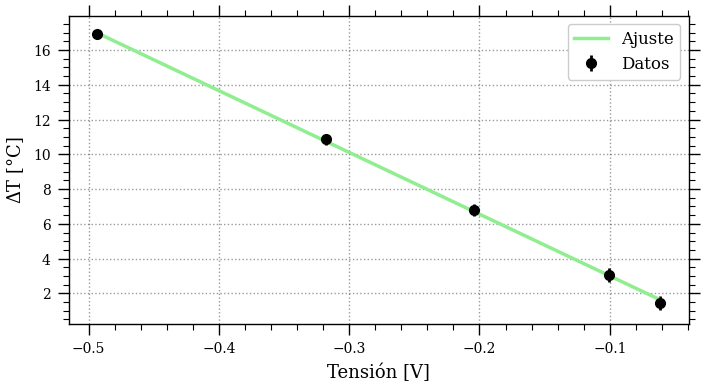

In [22]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.set_xlabel('Tensión [V]', fontsize=13, labelpad = 5)
ax.set_ylabel(r'$\Delta$T [°C]', fontsize=13, labelpad = 5)

ax.errorbar(VPeltier, deltaT, yerr=deltaT_sd,
            color='k', lw=2, marker='o', ls='', ms=7, label=f'Datos')
ax.plot(VPeltier, seebeck_f(VPeltier, *popt),label = f'Ajuste')


ax.tick_params(axis='both', which='major', labelsize=10,pad = 5)
ax.tick_params(axis='both', which='minor', labelsize=8)
ax.legend(fontsize = 'large')
fig.savefig('Figuras/Ajuste_seebeck.png', transparent= True)
plt.show()